# Setting & Preview

In [1]:
!pip install mtcnn

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras import regularizers
from keras import layers, models
from keras import optimizers, initializers, regularizers, metrics
import os
from PIL import Image
import numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import GlobalAveragePooling2D


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
real_directory = '/content/gdrive/My Drive/3-2_bigdata/data/real_and_fake_face/training/training_real/'
fake_directory = '/content/gdrive/My Drive/3-2_bigdata/data/real_and_fake_face/training/training_fake/'

real_crop_directory = '/content/gdrive/My Drive/3-2_bigdata/data_crop/real_and_fake_face/training/training_real/'
fake_crop_directory = '/content/gdrive/My Drive/3-2_bigdata/data_crop/real_and_fake_face/training/training_fake/'

crop_datadir = '/content/gdrive/My Drive/3-2_bigdata/data_crop/real_and_fake_face/training/'
datadir = '/content/gdrive/My Drive/3-2_bigdata/data/real_and_fake_face/training/'

real = os.listdir(real_directory)
fake = os.listdir(fake_directory)
crop_fake = os.listdir(fake_crop_directory)
crop_real = os.listdir(real_crop_directory)

In [4]:
print(len(crop_real))

1003


In [5]:
print(len(crop_fake))

874


In [6]:
print(len(real))

6697


In [7]:
print(len(fake))

5458


시간상의 문제와 적은 데이터로 모델을 평가해보았을때 mobileNet이랑 VGG16이 높은 성능을 보여 original data에만 추가 data적용 

향후 crop_data도 추가하여 유의미한 결과가 나오면 추가할 계획입니다

mtcnn을 이용하여 bound box를 그리는 함수

In [8]:
def draw_image_with_boxes(filename, result_list, new_filename):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
    # show the plot
    pyplot.show()

    img2 = cv2.imread(filename)
    cropped_image = img2[y:y+height, x:x+width]
    plt.imshow(cropped_image)
    cv2.imwrite(new_filename, cropped_image)


    return(x,y,x+width,y+height)

image crop 예시

[{'box': [152, 147, 344, 424], 'confidence': 0.9999252557754517, 'keypoints': {'left_eye': (288, 317), 'right_eye': (448, 304), 'nose': (402, 393), 'mouth_left': (315, 486), 'mouth_right': (448, 473)}}]


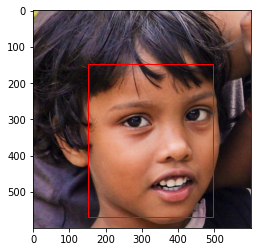

(152, 147, 496, 571)

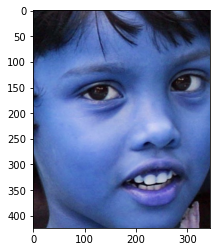

In [9]:
filename = os.path.join(real_directory,'real_00001.jpg')

new_filename = os.path.join(real_crop_directory,'real_00001.jpg')

detector = MTCNN()
# detect faces in the image
img = cv2.imread(filename)

faces = detector.detect_faces(img)
print(faces)

# display faces on the original image
draw_image_with_boxes(filename, faces,new_filename)


plot을 할 시 따로 색 변경을 하지 않아도 색이 바뀌는데 실제 crop_data를 살펴보면 원본의 색과 같다.

sample image view

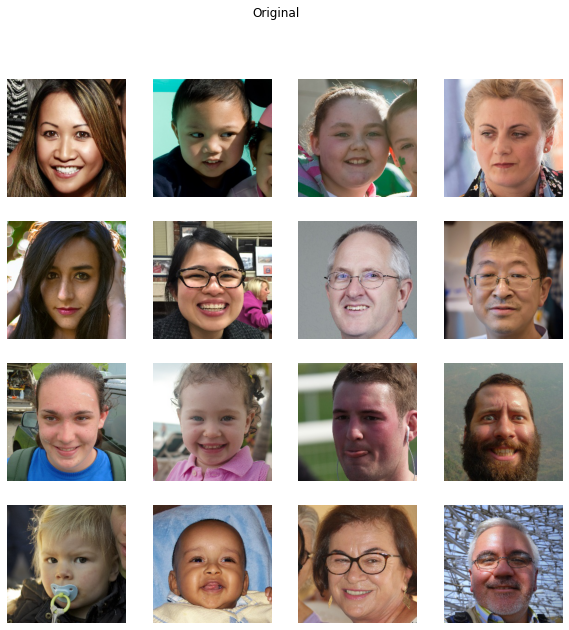

In [10]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4,4, i+1)
    image = plt.imread(real_directory + real[i])
    plt.imshow(image)
    plt.suptitle("Original")
    plt.axis('off')
    
plt.show()

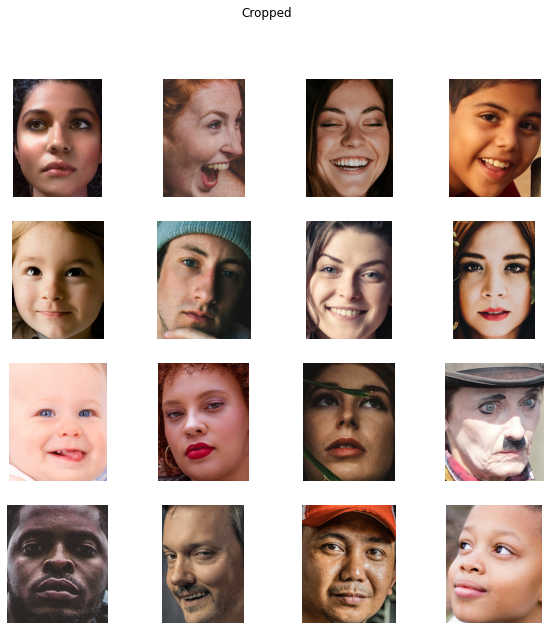

In [11]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4,4, i+1)
    image = plt.imread(real_crop_directory + crop_real[i])
    plt.imshow(image)
    plt.suptitle("Cropped")
    plt.axis('off')
    
plt.show()

crop_data는 colab으로 저장이 힘들어 pycharm을 이용해 따로 코드를 구현하였다.

# Data Preprocessing


In [12]:
epochs = 30
batch_size = 32

argument 적용해도 성능이 좋아지지 않아 미적용

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

In [16]:
steps_per_epoch = 40
validation_steps = 8

학습할수록 learning rate가 낮아지도록 설정

In [17]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

# CNN (batch nomalization, Max pooling,(128,128))

In [18]:
train_1 = train_datagen.flow_from_directory(crop_datadir,
                                          class_mode="binary",
                                          target_size=(128, 128),
                                          batch_size=batch_size,
                                          subset="training",
                                          shuffle =True)

Found 1503 images belonging to 2 classes.


In [19]:
val_1 = train_datagen.flow_from_directory(crop_datadir,
                                          class_mode="binary",
                                          target_size=(128, 128),
                                          batch_size=batch_size,
                                          subset="validation",
                                          shuffle = True
                                          )

Found 374 images belonging to 2 classes.


In [21]:
model_1=Sequential()

model_1.add(Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Dropout(0.2))


model_1.add(Conv2D(64,(3,3),activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Dropout(0.2))


model_1.add(Conv2D(128,(3,3),activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Dropout(0.2))


model_1.add(Flatten())
model_1.add(Dense(512,activation='relu'))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.5))
model_1.add(Dense(1,activation='sigmoid'))




In [22]:
model_1.compile(loss='binary_crossentropy', optimizer='adam',metrics=['acc'])

In [23]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [24]:
history_1 = model_1.fit_generator(train_1,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=val_1,
                              callbacks = [lr_callbacks],
                              validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
40/40 [==============================] - 9s 193ms/step - loss: 1.0127 - acc: 0.5786 - val_loss: 2.9939 - val_acc: 0.4961 - lr: 0.0010
Epoch 2/30
40/40 [==============================] - 7s 184ms/step - loss: 0.7907 - acc: 0.6169 - val_loss: 2.3076 - val_acc: 0.4375 - lr: 0.0010
Epoch 3/30
40/40 [==============================] - 7s 187ms/step - loss: 0.6908 - acc: 0.6693 - val_loss: 2.0332 - val_acc: 0.4688 - lr: 0.0010
Epoch 4/30
40/40 [==============================] - 7s 181ms/step - loss: 0.6188 - acc: 0.7000 - val_loss: 1.7203 - val_acc: 0.4453 - lr: 1.0000e-04
Epoch 5/30
40/40 [==============================] - 7s 180ms/step - loss: 0.5319 - acc: 0.7451 - val_loss: 1.2527 - val_acc: 0.4414 - lr: 1.0000e-04
Epoch 6/30
40/40 [==============================] - 7s 182ms/step - loss: 0.5546 - acc: 0.7295 - val_loss: 1.0383 - val_acc: 0.4766 - lr: 1.0000e-04
Epoch 7/30
40/40 [==============================] - 7s 183ms/step - loss: 0.5254 - acc: 0.7443 - val_loss: 1.3006 - va

In [25]:
model_1.save_weights('/content/gdrive/My Drive/3-2_bigdata/model_1.h5')

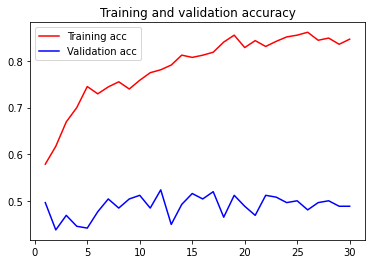

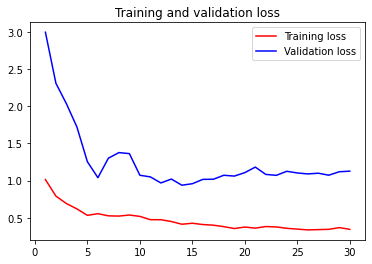

In [26]:
import matplotlib.pyplot as plt

acc = history_1.history['acc'] 
val_acc = history_1.history['val_acc'] 
loss = history_1.history['loss'] 
val_loss = history_1.history['val_loss']

epochs_1 = range(1, len(acc) + 1)

plt.plot(epochs_1, acc, 'r', label='Training acc') 
plt.plot(epochs_1, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs_1, loss, 'r', label='Training loss') 
plt.plot(epochs_1, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

# CNN2 (no batch nomalization, Average Pooling,(128,128))

In [27]:
train_2 = train_datagen.flow_from_directory(crop_datadir,
                                          class_mode="binary",
                                          target_size=(128, 128),
                                          batch_size=batch_size,
                                          subset="training",
                                          shuffle =True)

Found 1503 images belonging to 2 classes.


In [28]:
val_2 = train_datagen.flow_from_directory(crop_datadir,
                                          class_mode="binary",
                                          target_size=(128, 128),
                                          batch_size=batch_size,
                                          subset="validation",
                                          shuffle = True
                                          )

Found 374 images belonging to 2 classes.


In [29]:
model_2 = Sequential()

model_2.add(Conv2D(32,(3,3),input_shape = (128,128,3),activation = 'relu', padding='same'))
model_2.add(AveragePooling2D(pool_size=(2,2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_2.add(AveragePooling2D((2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_2.add(AveragePooling2D((2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Flatten())

model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(1, activation='sigmoid'))



In [30]:
model_2.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['acc'])

In [31]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 average_pooling2d (AverageP  (None, 64, 64, 32)       0         
 ooling2D)                                                       
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 32, 32, 64)       0         
 ePooling2D)                                                     
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 64)       

In [32]:
history_2 = model_2.fit_generator(train_2,
                     validation_data=val_2,
                     epochs = epochs,
                     callbacks = [lr_callbacks],
                     steps_per_epoch=steps_per_epoch,
                     validation_steps=validation_steps
                   )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
40/40 [==============================] - 8s 188ms/step - loss: 0.7501 - acc: 0.5098 - val_loss: 0.6923 - val_acc: 0.5312 - lr: 0.0010
Epoch 2/30
40/40 [==============================] - 7s 185ms/step - loss: 0.6922 - acc: 0.5297 - val_loss: 0.6914 - val_acc: 0.5352 - lr: 0.0010
Epoch 3/30
40/40 [==============================] - 7s 185ms/step - loss: 0.6924 - acc: 0.5285 - val_loss: 0.6922 - val_acc: 0.5234 - lr: 0.0010
Epoch 4/30
40/40 [==============================] - 7s 179ms/step - loss: 0.6921 - acc: 0.5238 - val_loss: 0.6902 - val_acc: 0.5469 - lr: 1.0000e-04
Epoch 5/30
40/40 [==============================] - 7s 177ms/step - loss: 0.6913 - acc: 0.5297 - val_loss: 0.6882 - val_acc: 0.5703 - lr: 1.0000e-04
Epoch 6/30
40/40 [==============================] - 7s 179ms/step - loss: 0.6910 - acc: 0.5317 - val_loss: 0.6928 - val_acc: 0.5156 - lr: 1.0000e-04
Epoch 7/30
40/40 [==============================] - 7s 184ms/step - loss: 0.6888 - acc: 0.5340 - val_loss: 0.6938 - va

In [33]:
model_2.save_weights('/content/gdrive/My Drive/3-2_bigdata/model_2.h5')

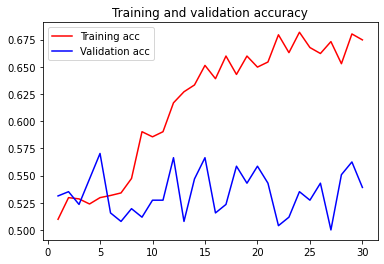

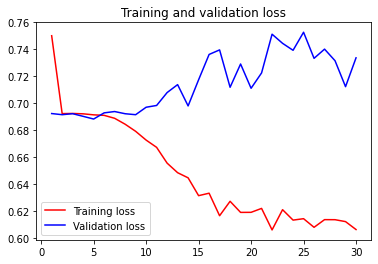

In [34]:
import matplotlib.pyplot as plt

acc = history_2.history['acc'] 
val_acc = history_2.history['val_acc'] 
loss = history_2.history['loss'] 
val_loss = history_2.history['val_loss']

epochs_2 = range(1, len(acc) + 1)

plt.plot(epochs_2, acc, 'r', label='Training acc') 
plt.plot(epochs_2, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs_2, loss, 'r', label='Training loss') 
plt.plot(epochs_2, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

# Mobilenet (224,224)

In [35]:
train_3 = train_datagen.flow_from_directory(datadir,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=batch_size*2,
                                          subset="training",
                                          shuffle =True)

Found 9725 images belonging to 2 classes.


In [36]:
val_3 = train_datagen.flow_from_directory(datadir,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=batch_size*2,
                                          subset="validation",
                                          shuffle = True
                                          )

Found 2430 images belonging to 2 classes.


In [37]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(224,224,3))

9420800/9406464 [==============================] - 0s 0us/step


In [38]:
tf.keras.backend.clear_session()

model_3 = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.2),
                    Dense(128, activation = "relu"),
                    Dropout(0.2),
                    Dense(32, activation = "relu"),
                    Dropout(0.5),
                    Dense(1, activation = "sigmoid")])

model_3.layers[0].trainable = False




In [39]:
model_3.compile(loss='binary_crossentropy', optimizer="adam", metrics = ['acc'])

In [40]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [41]:
history_3 = model_3.fit_generator(train_3,
                     validation_data=val_3,
                     epochs = epochs,
                     callbacks = [lr_callbacks],
                     steps_per_epoch=steps_per_epoch*3,
                     validation_steps=validation_steps*3
                   )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
120/120 [==============================] - 1217s 10s/step - loss: 0.6335 - acc: 0.6826 - val_loss: 0.5406 - val_acc: 0.7214 - lr: 0.0010
Epoch 2/30
120/120 [==============================] - 290s 2s/step - loss: 0.5122 - acc: 0.7573 - val_loss: 0.5157 - val_acc: 0.7298 - lr: 0.0010
Epoch 3/30
120/120 [==============================] - 95s 794ms/step - loss: 0.4616 - acc: 0.7896 - val_loss: 0.4823 - val_acc: 0.7643 - lr: 0.0010
Epoch 4/30
120/120 [==============================] - 54s 448ms/step - loss: 0.4269 - acc: 0.8096 - val_loss: 0.4603 - val_acc: 0.7728 - lr: 1.0000e-04
Epoch 5/30
120/120 [==============================] - 43s 363ms/step - loss: 0.4076 - acc: 0.8189 - val_loss: 0.4640 - val_acc: 0.7760 - lr: 1.0000e-04
Epoch 6/30
120/120 [==============================] - 40s 337ms/step - loss: 0.3993 - acc: 0.8201 - val_loss: 0.4436 - val_acc: 0.7865 - lr: 1.0000e-04
Epoch 7/30
120/120 [==============================] - 40s 331ms/step - loss: 0.3879 - acc: 0.8290 - va

In [42]:
model_3.save_weights('/content/gdrive/My Drive/3-2_bigdata/model_3.h5')

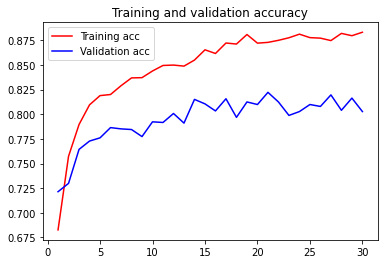

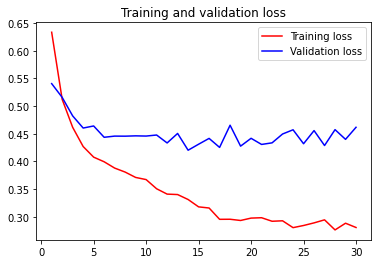

In [43]:
import matplotlib.pyplot as plt

acc = history_3.history['acc'] 
val_acc = history_3.history['val_acc'] 
loss = history_3.history['loss'] 
val_loss = history_3.history['val_loss']

epochs_3 = range(1, len(acc) + 1)

plt.plot(epochs_3, acc, 'r', label='Training acc') 
plt.plot(epochs_3, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs_3, loss, 'r', label='Training loss') 
plt.plot(epochs_3, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

# VGG16 (224,224)

In [44]:
train_4 = train_datagen.flow_from_directory(datadir,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=batch_size*2,
                                          subset="training",
                                          shuffle =True)

Found 9725 images belonging to 2 classes.


In [45]:
val_4 = train_datagen.flow_from_directory(datadir,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=batch_size*2,
                                          subset="validation",
                                          shuffle = True
                                          )

Found 2430 images belonging to 2 classes.


In [46]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

58900480/58889256 [==============================] - 0s 0us/step


In [47]:
model_4 = Sequential([vgg16_model,
                    Flatten(),
                    Dense(1, activation = "sigmoid")])

model_4.layers[0].trainable = False 


In [48]:
model_4.compile(loss='binary_crossentropy', optimizer="adam", metrics = ['acc'])


In [49]:
model_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [50]:
history_4 = model_4.fit_generator(train_4,
                     validation_data=val_4,
                     epochs = epochs,
                     callbacks = [lr_callbacks],
                     steps_per_epoch=steps_per_epoch*3,
                     validation_steps=validation_steps*3
                   )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
120/120 [==============================] - 51s 349ms/step - loss: 0.5495 - acc: 0.7245 - val_loss: 0.4683 - val_acc: 0.7669 - lr: 0.0010
Epoch 2/30
120/120 [==============================] - 46s 382ms/step - loss: 0.3887 - acc: 0.8282 - val_loss: 0.4473 - val_acc: 0.7839 - lr: 0.0010
Epoch 3/30
120/120 [==============================] - 41s 344ms/step - loss: 0.3308 - acc: 0.8568 - val_loss: 0.3948 - val_acc: 0.8294 - lr: 0.0010
Epoch 4/30
120/120 [==============================] - 42s 352ms/step - loss: 0.2752 - acc: 0.9077 - val_loss: 0.3834 - val_acc: 0.8307 - lr: 1.0000e-04
Epoch 5/30
120/120 [==============================] - 42s 346ms/step - loss: 0.2695 - acc: 0.9052 - val_loss: 0.3859 - val_acc: 0.8353 - lr: 1.0000e-04
Epoch 6/30
120/120 [==============================] - 42s 346ms/step - loss: 0.2617 - acc: 0.9116 - val_loss: 0.3836 - val_acc: 0.8320 - lr: 1.0000e-04
Epoch 7/30
120/120 [==============================] - 42s 347ms/step - loss: 0.2601 - acc: 0.9112 - 

In [51]:
model_4.save_weights('/content/gdrive/My Drive/3-2_bigdata/model_4.h5')

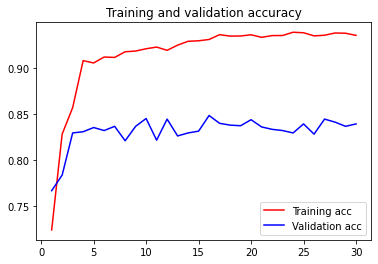

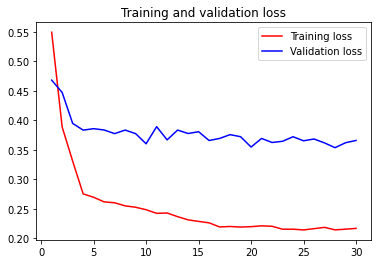

In [52]:
import matplotlib.pyplot as plt

acc = history_4.history['acc'] 
val_acc = history_4.history['val_acc'] 
loss = history_4.history['loss'] 
val_loss = history_4.history['val_loss']

epochs_4 = range(1, len(acc) + 1)

plt.plot(epochs_4, acc, 'r', label='Training acc') 
plt.plot(epochs_4, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs_4, loss, 'r', label='Training loss') 
plt.plot(epochs_4, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

# Model prediction

In [53]:
test_dir_crop = '/content/gdrive/My Drive/3-2_bigdata/data_crop/real_and_fake_face/test/'

In [54]:
test_dir = '/content/gdrive/My Drive/3-2_bigdata/data/real_and_fake_face/test/'

In [55]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [56]:
test_generator_1 = test_datagen.flow_from_directory(
        test_dir_crop,
        target_size=(128, 128),    
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 130 images belonging to 2 classes.


In [57]:
test_generator_2 = test_datagen.flow_from_directory(
        test_dir_crop,
        target_size=(128, 128),    
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 130 images belonging to 2 classes.


In [58]:
test_generator_3 = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),    
        batch_size=batch_size*2,
        class_mode='binary',
        shuffle=False)

Found 3105 images belonging to 2 classes.


In [59]:
test_generator_4 = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),    
        batch_size=batch_size*2,
        class_mode='binary',
        shuffle=False)

Found 3105 images belonging to 2 classes.


In [60]:
loss_and_metrics_1 = model_1.evaluate_generator(test_generator_1, steps=5)
print("Test Loss: ", loss_and_metrics_1[0])
print("Test Accuracy: ", loss_and_metrics_1[1])
test_generator_1.reset()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Test Loss:  0.9182996153831482
Test Accuracy:  0.5692307949066162


In [68]:
loss_and_metrics_2 = model_2.evaluate_generator(test_generator_2, steps=5)
print("Test Loss: ", loss_and_metrics_2[0])
print("Test Accuracy: ", loss_and_metrics_2[1])
test_generator_2.reset()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Test Loss:  0.6630391478538513
Test Accuracy:  0.6000000238418579


In [69]:
loss_and_metrics_3 = model_3.evaluate_generator(test_generator_3, steps=20)
print("Test Loss: ", loss_and_metrics_3[0])
print("Test Accuracy: ", loss_and_metrics_3[1])
test_generator_3.reset()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Test Loss:  0.48039746284484863
Test Accuracy:  0.797656238079071


In [70]:
loss_and_metrics_4 = model_4.evaluate_generator(test_generator_4, steps=30)
print("Test Loss: ", loss_and_metrics_4[0])
print("Test Accuracy: ", loss_and_metrics_4[1])
test_generator_4.reset()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Test Loss:  0.3710648715496063
Test Accuracy:  0.8364583253860474


# Model Comparison

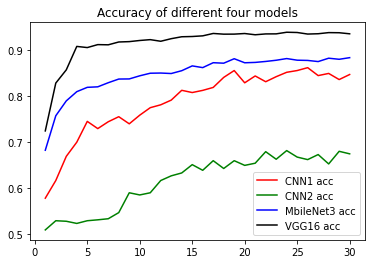

In [71]:
# Model_1~4 : Training accuracy 시각화
acc_1 = history_1.history['acc'] 
acc_2 = history_2.history['acc']
acc_3 = history_3.history['acc']
acc_4 = history_4.history['acc']

epochs_5 = range(1, epochs+1)


plt.plot(epochs_5, acc_1, 'r', label='CNN1 acc') 
plt.plot(epochs_5, acc_2, 'g', label='CNN2 acc')
plt.plot(epochs_5, acc_3, 'b', label='MbileNet3 acc') 
plt.plot(epochs_5, acc_4, 'k', label='VGG16 acc')  
plt.title('Accuracy of different four models') 
plt.legend()
plt.show()

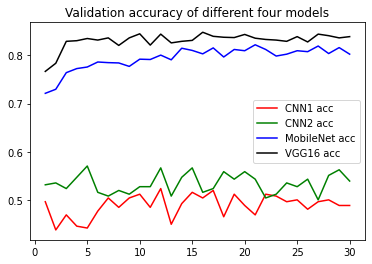

In [72]:
# Model_1~4 : Validation accuracy 시각화
val_acc_1 = history_1.history['val_acc'] 
val_acc_2 = history_2.history['val_acc']
val_acc_3 = history_3.history['val_acc']
val_acc_4 = history_4.history['val_acc']

epochs_6 = range(1, epochs+1)

plt.plot(epochs_6, val_acc_1, 'r', label='CNN1 acc') 
plt.plot(epochs_6, val_acc_2, 'g', label='CNN2 acc')
plt.plot(epochs_6, val_acc_3, 'b', label='MobileNet acc') 
plt.plot(epochs_6, val_acc_4, 'k', label='VGG16 acc')  
plt.title('Validation accuracy of different four models') 
plt.legend()
plt.show()

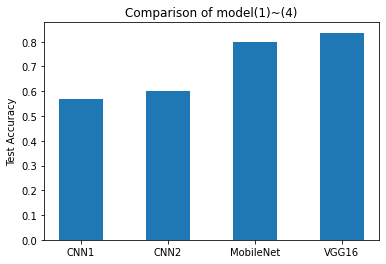

In [73]:
# 4개 model : Test accuracy 시각화
all_accuracies = [loss_and_metrics_1[1],loss_and_metrics_2[1],loss_and_metrics_3[1],loss_and_metrics_4[1]]
plt.bar(["CNN1","CNN2","MobileNet","VGG16"], all_accuracies,  width=0.5) 

plt.ylabel("Test Accuracy") 
plt.title("Comparison of model(1)~(4)") 
plt.show()

# Result

CNN1과 CNN2를 비교해 보았을때 tarin acc에서는 CNN1모델이 더 좋은 성능을 보이며, test acc,validation acc 는 비슷한 성능을 보이는 것을 알 수 있다.


CNN1,2와 MobilNet,VGG16을 비교해 보았을때 CNN 모델들은 overfitting이 일어나는 반면 MobileNet과 VGG16은 양호하게 학습됨을 알 수 있다. 
이는 data의 양의 문제로 판단된다.

MobileNet과 VGG16을 비교해 보았을때 VGG16이 test acc에서 조금 더 나은 성능을 내는 것을 알 수 있다. 

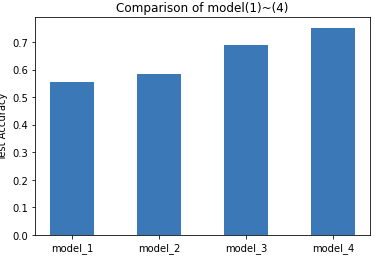

위 사진은 데이터의 갯수가 적을때의 test acc이다. 보는바와같이 mobileNet과 VGG16의 성능이 비교적 좋다고 판단해 original data에만 우선적으로 data를 추가해 보았다.